In [1]:
from filterpy.kalman import EnsembleKalmanFilter as EnKF
from filterpy.common import Q_discrete_white_noise

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal
from filterpy.stats import (covariance_ellipse, 
                            plot_covariance_ellipse, plot_covariance)
import matplotlib
import matplotlib.ticker as tck

from scipy.integrate import solve_ivp 
from numba import jit
#from numbalsoda import lsoda_sig, lsoda
from numba import njit, cfunc
import time
np.random.seed(3)

matplotlib.rcParams["xtick.labelsize"]=18
matplotlib.rcParams["ytick.labelsize"]=18 
matplotlib.rcParams["axes.labelsize"]=20
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

%matplotlib inline


## The ANAC4 system 
The ANAC4 system is a second-order differential equation which can be written as a coupled system of first order differential equation designed to mimic the behaviour of sawtooth oscillations. It is written 
\begin{align} 
    \dot{a} &= v,\\
    \dot{v} &= \mu a + 2 \sigma a^3. 
\end{align}
For this notebook, we will use the value $\mu = 10$ and $\sigma =-0.1$ to generate the observational data. This generates a symmetry breaking solution where the particle can get trapped in one side of the potential well for specific initial conditions. 


In [2]:
#specify the integration model, jit decorator can be used for speed but is not essential 
@jit
def anac(x, dt):
    return np.array([x[1], x[2]*x[0] + 2*x[3]*x[0]**3, 0, 0])

@jit
def runge_fx(x, dt):
    
    k1 = anac(x, dt)
    k2 = anac(x + 0.5*dt*k1, dt)
    k3 = anac(x + 0.5*dt*k2, dt )
    k4 = anac(x + dt*k3, dt)
    x = x + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return x
    

# Generate synthetic data
def generate_data(steps, x0 = np.array([1.5, 1.,10., -0.1]), dt_phase_model=0.01, std=0.1):
    np.random.seed(1234) #this isn't how you should set the seed now
    observations = np.zeros((steps,x0.shape[0]))
    observation_times = []
    tcounter = 0
    for i in range(steps):
        x0 = runge_fx(x0, dt_phase_model)
        tcounter+=dt_phase_model
        observation_times.append(tcounter)
        observations[i] = x0 #+ np.random.normal(0,std, size=x0.shape[0])

    for i in range(x0.shape[0]):
        observations[:,i]+=np.random.normal(0,std, size=steps)
    return observations, np.array(observation_times)


## Generate the observational dataset 
We generate the observational dataset using Runge-Kutta method with additive noise and downsampling.

Observational data characteristics
Period 2.0689655172413794
Samples per period 16


Text(0, 0.5, '$\\dot{a}$')

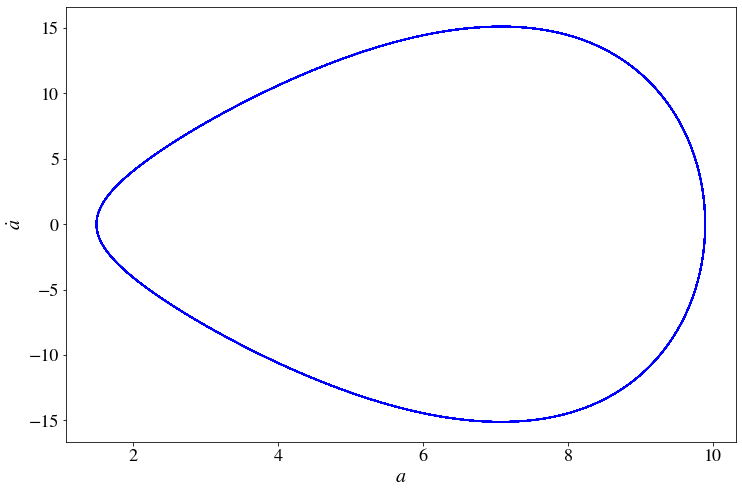

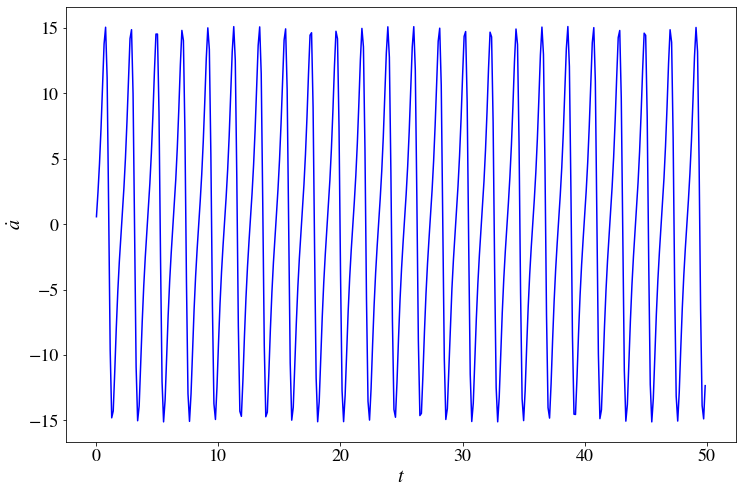

In [3]:
true_params = [10, -0.1] #true model parameters
std = 0.1 #standard deviation of additive noise
# Parameters
dt_assim = 0.01
dt_phase_model = 0.005
steps = 10000

# Generate synthetic data
observations, observation_times = generate_data(steps,
                                                x0 = np.array([1.5, 
                                                               0.5, 
                                                               10, -0.1 ]),
                                                dt_phase_model=dt_phase_model, std=0)


plt.figure(figsize=(12,8))
plt.plot(observations[:,0], observations[:,1], "b") 
plt.xlabel(r"$a$")
plt.ylabel(r"$\dot{a}$")

########### downsample the data
observation_sub = 25
period=2.0689655172413794
observations= observations[::observation_sub,:2]

observation_times = observation_times[::observation_sub] 
observational_nu =int(period//(dt_phase_model*observation_sub))

print("Observational data characteristics")
print("Period", period)
print("Samples per period", observational_nu)

plt.figure(figsize=(12,8))
plt.plot(observation_times, observations[:,1], "b") 
plt.xlabel(r"$t$")
plt.ylabel(r"$\dot{a}$")

### Assimilation with the ANAC model 
We demonstrate the full functionality of the code by first assimilating observations from the ANAC model above which can be made noiser or sparser. 

For EnKF, we must specify:
- $\boldsymbol{R}$ the measurement uncertainty
- $\boldsymbol{P}$ the initial uncertainty or covariance matrix, included elements are variances
- $\boldsymbol{x}$ at $t = 0$, or the initial conditions
- $\boldsymbol{H}$ the observation operator

In the following example we perturb the true initial condition from the artificial time series generated in the previous section. However, it is much more sensible to initialise the observed variables as the first observation in the dataset (giving random initial conditions for observed variables does not make sense anyway).

We first begin by specifying the observation operator $\boldsymbol{H}$ and initial states and covariances.

In [4]:
def hx(x):
    return [x[0], x[1]]  

np.random.seed(1)
initial_covariance = np.eye(4) *9
initial_covariance[-1, -1] = 1

perturb = np.random.uniform(low=-1, high=1, size= 4) #perturbation to the initial condtions
initial_state = np.array([1.5, 0.5, 10, -0.1]) + perturb

print("True initial condition") 
print([1.5, 1,10., -0.1])
print("Perturbed initial condition") 
print(initial_state) 

True initial condition
[1.5, 1, 10.0, -0.1]
Perturbed initial condition
[ 1.33404401  0.94064899  9.00022875 -0.49533485]


### Instantiating the EnKF class
We can now instantiate the EnKF class by calling EnKF and specifying the initialising variables.

In [5]:
# Ensemble Kalman Filter setup
enkf = EnKF(x=initial_state, #initial mean
            inf=1, #inflation factor (added in CCFE code) 
            inf_a = None, #analysis inflation
            gauss_kick = None, #uniform process noise
            P=initial_covariance, #initial uncertainty
            dim_z=2, #number of observations
            dt=dt_phase_model, #integration time-step 
            hx=hx, #observation function
            N=30, #number of ensemble members
            fx=runge_fx, #nonlinear SSM
            ensemble_type="gsn", #initial prior distribution
            constraints = None, #include tuple of counstraints
            seed=1
           )

In [6]:
"""
We also specify the process noise matrix Q which is set to be zero as the model is exactly correct 
in this example

We also specify the measurement uncertainty matrix as the expected variance of the noise added to the 
observations
"""
Q = np.zeros((4,4)) #set the process noise to zero as in the CCFE code
enkf.Q = Q 
enkf.R = np.diag([std**2, std**2]) #measuremement uncertainty


## Performing assimilation
We are now ready to assimilate observations using EnKF. For this, we specify the points we will assimilate at and if there is an oservation available, EnKF will update the estimates

In [7]:
time_prediction = np.arange(0,observation_times[-1]+dt_phase_model, dt_phase_model)

# Run the filter
estimates = np.zeros((time_prediction.shape[0], initial_state.shape[0]))
estimates[0,:] = initial_state
Pmat = np.zeros((time_prediction.shape[0], initial_state.shape[0], initial_state.shape[0])) 
Pmat[0,:,:] = initial_covariance
update_counter = 0 

#perform filtering
for ii, t in enumerate(time_prediction[1:]) :

    #assimilate observations if they are considered contemporary 
    if np.isclose(t, observation_times[1:], rtol =1e-8, atol=dt_phase_model*1e-8).any():
        enkf.predict(True)
        enkf.update(observations[np.isclose(t, observation_times, rtol =1e-8,
                                            atol=dt_phase_model*1e-8),:][0])
        update_counter+=1

    #else integrate the ensemble members forward in time 
    else:
        enkf.predict(True) #If false does not calculate posterior matrix which can save computational time
        
    estimates[ii+1,:] = np.copy(enkf.x)  # Extract only state variables from the state vector
    Pmat[ii+1,:,:] = np.copy(enkf.P) #extract the posteriors
    
print("updated", update_counter, "times") 
print("Final covariance P matrix") 
print(enkf.P) 

updated 399 times
Final covariance P matrix
[[ 1.95714606e-05 -2.25103866e-05 -2.43450908e-05  4.82690804e-07]
 [-2.25103866e-05  5.54073173e-05 -4.90425474e-06 -1.24378121e-07]
 [-2.43450908e-05 -4.90425474e-06  6.74634156e-05 -1.13215681e-06]
 [ 4.82690804e-07 -1.24378121e-07 -1.13215681e-06  2.36065206e-08]]


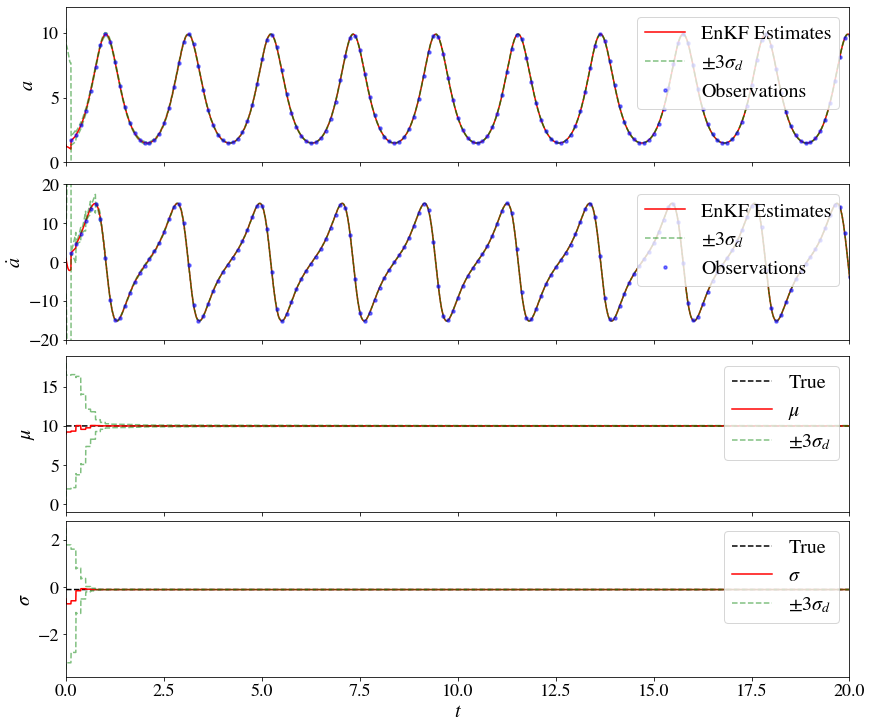

In [8]:
fig, ax = plt.subplots(4,1, figsize=(12, 10), sharex=True, layout="constrained")

ax[0].plot(time_prediction, estimates[:, 0], label='EnKF Estimates', color='r')

ax[0].plot(time_prediction, estimates[:, 0]+3*np.sqrt(Pmat[:,0,0]), color='g', 
          linestyle="--", alpha=0.5)
ax[0].plot(time_prediction, estimates[:, 0]-3*np.sqrt(Pmat[:,0,0]), color='g',
          linestyle="--", alpha=0.5, label=r"$\pm 3\sigma_d$")
ax[0].plot(observation_times[1:], observations[1:, 0], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
#ax[0].fill_between(range(len(estimates[:,0])), estimates[:, 0]+np.sqrt(Pmat[:,0,0]), 
#                  estimates[:, 0]-np.sqrt(Pmat[:,0,0]),
#                     facecolor='yellow', alpha=0.2, interpolate=True)
ax[0].legend(loc="upper right", fontsize=20)
ax[0].set_ylim((0,12))
ax[1].set_xlim((0, 20)) 
ax[0].set_ylabel(r"$a$")

ax[1].plot(time_prediction, estimates[:, 1], label='EnKF Estimates', color='r')
ax[1].plot(time_prediction, estimates[:, 1]+3*np.sqrt(Pmat[:,1,1]), color='g', 
          linestyle="--" , alpha=0.5)
ax[1].plot(time_prediction, estimates[:, 1]-3*np.sqrt(Pmat[:,1,1]), color='g',
          linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)

ax[1].plot(observation_times[1:], observations[1:, 1], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
ax[1].legend(loc="upper right", fontsize=20)
ax[1].set_ylabel(r"$\dot{a}$")
ax[1].set_ylim((-20,20))

colours = ["r", "b", "g"]
param_labels = [r"$\mu$", r"$\sigma$"]
for i in range(2):
    ax[i+2].plot(time_prediction, np.ones(estimates.shape[0])*true_params[i], "--k", 
                label="True")
    ax[i+2].plot(time_prediction, estimates[:,i+2], c="r", label = param_labels[i]) 
    ax[i+2].plot(time_prediction, estimates[:, i+2]+3*np.sqrt(Pmat[:,i+2,i+2]), color='g', 
          linestyle="--" , alpha=0.5)
    ax[i+2].plot(time_prediction, estimates[:, i+2]-3*np.sqrt(Pmat[:,i+2,i+2]), color='g',
              linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)
    ax[i+2].legend(loc="upper right", fontsize=20) 
ax[2].set_ylabel(r"$\mu$")
ax[3].set_ylabel(r"$\sigma$")
ax[3].set_xlabel(r"$t$")
plt.savefig("two_state_measurement.pdf", 
            bbox_inches="tight") 


## Single state observation of the ANAC model
We generate an example code to recreate previous results of the CCFE code. We generate observations from the ANAC model above and using observations of only $\dot{a}$ fit the state variables and the parameters.

For this example we generate a single set of observations. 

Observational data characteristics
Period 2.0689655172413794
Samples per period 12


Text(0, 0.5, '$\\dot{a}$')

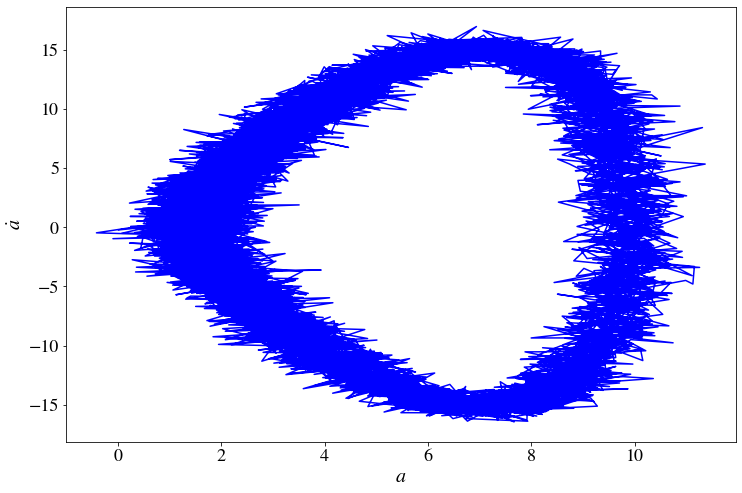

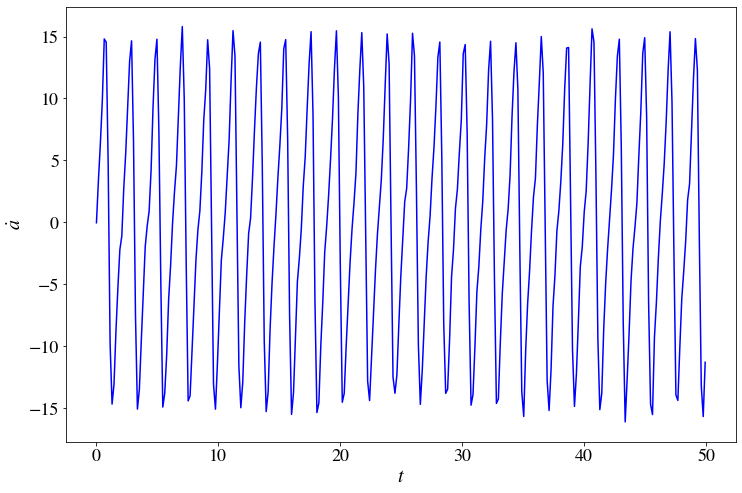

In [9]:

@jit
def anac(x, dt):
    return np.array([x[1], x[2]*x[0] + 2*x[3]*x[0]**3, 0, 0])

@jit
def runge_fx(x, dt):
    
    k1 = anac(x, dt)
    k2 = anac(x + 0.5*dt*k1, dt)
    k3 = anac(x + 0.5*dt*k2, dt )
    k4 = anac(x + dt*k3, dt)
    x = x + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return x
    

# Generate synthetic data
def generate_data(steps, x0 = np.array([1.5, 1.,10., -0.1]), dt_phase_model=0.01, std=0.1):
    np.random.seed(1234)
    observations = np.zeros((steps,x0.shape[0]))
    observation_times = []
    tcounter = 0
    for i in range(steps):
        x0 = runge_fx(x0, dt_phase_model)
        tcounter+=dt_phase_model
        observation_times.append(tcounter)
        observations[i] = x0 + np.random.normal(0,std, size=x0.shape[0])
    return observations, np.array(observation_times)

true_params = [10, -0.1]
std = 0.5 #standard deviation of additive noise
# Parameters
dt_assim = 0.01
dt_phase_model = 0.005
steps = 10000

# Generate synthetic data
observations, observation_times = generate_data(steps,
                                                x0 = np.array([1.5, 0.5, 10, -0.1]),
                                                dt_phase_model=dt_phase_model, std=std)


plt.figure(figsize=(12,8))
plt.plot(observations[:,0], observations[:,1], "b") 
plt.xlabel(r"$a$")
plt.ylabel(r"$\dot{a}$")

########### downsample the data

#enkf.Q[:3,:3] = Q
observation_sub = 32
period=2.0689655172413794
#observations= observations[::observation_sub,:2]
observations= np.reshape(observations[::observation_sub,1], 
                         (observations[::observation_sub,1].shape[0], 1))
observation_times = observation_times[::observation_sub] 
observational_nu =int(period//(dt_phase_model*observation_sub))

print("Observational data characteristics")
print("Period", period)
print("Samples per period", observational_nu)

plt.figure(figsize=(12,8))
plt.plot(observation_times, observations[:], "b") 
plt.xlabel(r"$t$")
plt.ylabel(r"$\dot{a}$")


In [29]:
#define the observation operator (only adot) 
def hx(x):
    return x[1] 
initial_covariance = np.eye(4) * 2
initial_covariance[-1, -1] = 0.5
perturb = np.random.uniform(low=-10, high=10, size= 4)
perturb[-1] = np.random.uniform(low=-1, high=1) #sigma perturbation must be limited as becomes unstable
initial_state = np.array([1.5, 1, 10., -0.5]) + perturb
 
# perturb initial state and parameters
print("True initial condition") 
print([1.5, 1,10., -0.1])
print("Perturbed initial condition") 
print(initial_state) 

#example of constraints on the sigma parameter enforcing an upper bound 
constraints = np.array([
                       [None, None, None, None],
                       [None, None, None, -1e-16]
                       ])

# Ensemble Kalman Filter setup
enkf = EnKF(x=initial_state, #initial mean
            inf=1.00, #inflation factor (added in CCFE code) 
            inf_a = None,
            P=initial_covariance, #initial uncertainty
            dim_z=1, #number of observations
            dt=dt_phase_model, #integration time-step (not really used) 
            hx=hx, #observation function
            N=50, #number of ensemble members
            fx=runge_fx, #nonlinear SSM
            ensemble_type="gsn",
            constraints = None, #constraints can be included on sigma if desired
            gauss_kick = None, 
            qscales = None, 
            seed=1
           )

True initial condition
[1.5, 1, 10.0, -0.1]
Perturbed initial condition
[ 1.60877646 -3.62219956  3.20999446 -0.40456022]


In [30]:
Q = np.zeros((4,4)) #set the process noise to zero as in the CCFE code
# about when this is added

enkf.Q = Q 
enkf.R = np.diag([std**2]) #measuremement uncertainty

In [31]:
Q = np.zeros((4,4)) #set the process noise to zero as in the CCFE code
# about when this is added

enkf.Q = Q 


enkf.R = np.diag([std**2]) #measuremement uncertainty



time_prediction = np.arange(0,observation_times[-1], dt_phase_model)

# Run the filter
estimates = np.zeros((time_prediction.shape[0], initial_state.shape[0]))
Pmat = np.zeros((time_prediction.shape[0], initial_state.shape[0], initial_state.shape[0])) 
update_counter = 0 

#perform filtering
for ii, t in enumerate(time_prediction) :

    #assimilate observations if they are considered contemporary 
    if np.isclose(t, observation_times[1:], rtol =1e-8, atol=dt_phase_model*1e-8).any():
        enkf.predict(True)
        enkf.update(observations[np.isclose(t, observation_times, rtol =1e-8,
                                            atol=dt_phase_model*1e-8),:][0])
        update_counter+=1

    #else integrate the ensemble members forward in time 
    else:
        enkf.predict(True)
    estimates[ii,:] = np.copy(enkf.x)  # Extract only state variables from the state vector
    Pmat[ii,:,:] = np.copy(enkf.P)
    
print("updated", update_counter, "times") 
print("Final covariance P matrix") 
print(enkf.P) 

updated 312 times
Final covariance P matrix
[[ 2.85692057e-03 -4.80241858e-03 -7.40211308e-04  1.45115678e-05]
 [-4.80241858e-03  1.21643190e-02 -1.84174220e-04 -4.24922127e-06]
 [-7.40211308e-04 -1.84174220e-04  1.96519052e-03 -3.45892964e-05]
 [ 1.45115678e-05 -4.24922127e-06 -3.45892964e-05  7.64455972e-07]]


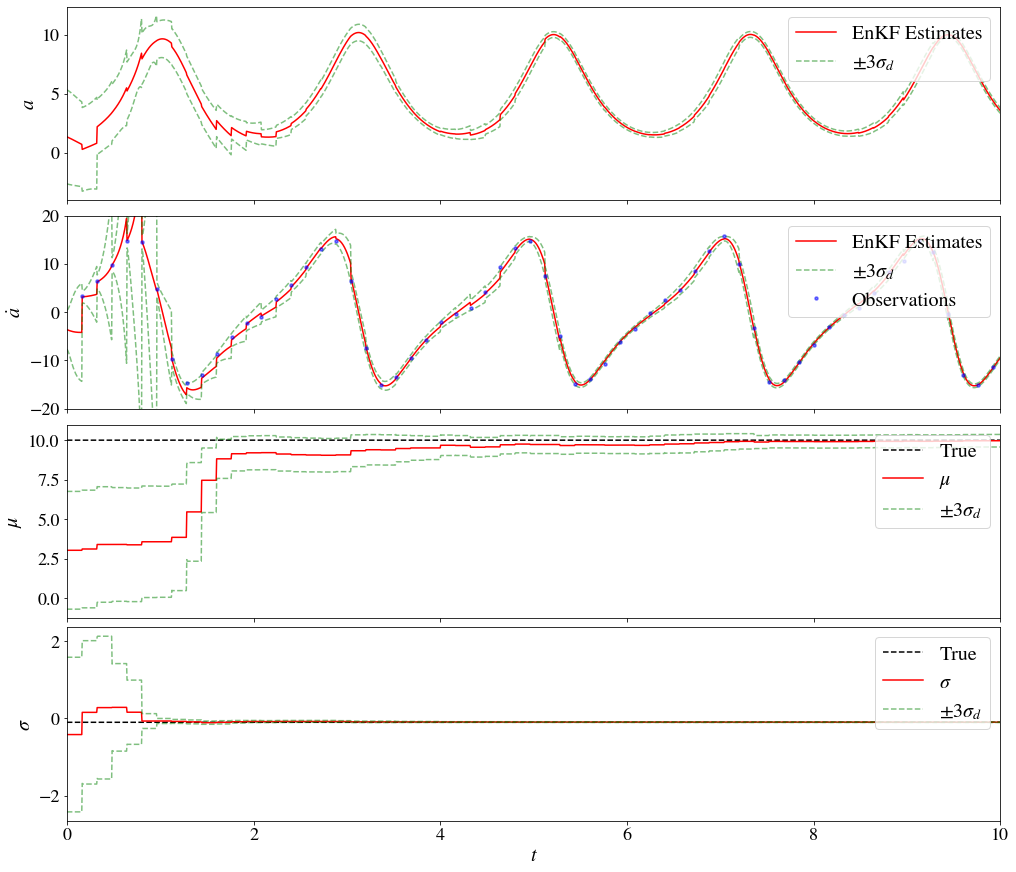

In [32]:
fig, ax = plt.subplots(4,1, figsize=(14, 12), sharex=True, layout="constrained")

ax[0].plot(time_prediction, estimates[:, 0], label='EnKF Estimates', color='r')

ax[0].plot(time_prediction, estimates[:, 0]+3*np.sqrt(Pmat[:,0,0]), color='g', 
          linestyle="--", alpha=0.5)
ax[0].plot(time_prediction, estimates[:, 0]-3*np.sqrt(Pmat[:,0,0]), color='g',
          linestyle="--", alpha=0.5, label=r"$\pm 3\sigma_d$")


ax[0].legend(loc="upper right", fontsize=20)
ax[1].set_xlim((0, 10)) 
ax[0].set_ylabel(r"$a$")

ax[1].plot(time_prediction, estimates[:, 1], label='EnKF Estimates', color='r')
ax[1].plot(time_prediction, estimates[:, 1]+3*np.sqrt(Pmat[:,1,1]), color='g', 
          linestyle="--" , alpha=0.5)
ax[1].plot(time_prediction, estimates[:, 1]-3*np.sqrt(Pmat[:,1,1]), color='g',
          linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)

ax[1].plot(observation_times[1:], observations[1:], label='Observations', color='b',  marker="o",
           alpha=0.5, linestyle="", markersize=3, markeredgewidth=1.5)
ax[1].legend(loc="upper right", fontsize=20)
ax[1].set_ylabel(r"$\dot{a}$")
ax[1].set_ylim((-20,20))

colours = ["r", "b", "g"]
param_labels = [r"$\mu$", r"$\sigma$"]
for i in range(2):
    ax[i+2].plot(time_prediction, np.ones(estimates.shape[0])*true_params[i], "--k", 
                label="True")
    ax[i+2].plot(time_prediction, estimates[:,i+2], c="r", label = param_labels[i]) 
    ax[i+2].plot(time_prediction, estimates[:, i+2]+3*np.sqrt(Pmat[:,i+2,i+2]), color='g', 
          linestyle="--" , alpha=0.5)
    ax[i+2].plot(time_prediction, estimates[:, i+2]-3*np.sqrt(Pmat[:,i+2,i+2]), color='g',
              linestyle="--", label=r"$\pm 3\sigma_d$", alpha=0.5)
    ax[i+2].legend(loc="upper right", fontsize=20) 
ax[2].set_ylabel(r"$\mu$")
ax[3].set_ylabel(r"$\sigma$")
ax[3].set_xlabel(r"$t$")
plt.savefig("single_state_measurement.pdf", 
            bbox_inches="tight") 
